# Intent Recognition with BERT using Keras and TensorFlow 2

In [0]:
!nvidia-smi

In [2]:
!pip install tensorflow-gpu >> /dev/null

ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [0]:
!pip install --upgrade grpcio >> /dev/null

In [0]:
!pip install tqdm  >> /dev/null

In [0]:
!pip install bert-for-tf2 >> /dev/null

In [0]:
!pip install sentencepiece >> /dev/null

In [0]:
import os, glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Data

Unzip swda.zip and drop all the extra columns keep text and tag and create three datasets in train.csv, val.csv and test.csv 

In [0]:
!unzip swda.zip > /dev/null

In [0]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)
result.to_csv('swda_all_data.csv',index=False)

In [147]:
reduced_df = result[['act_tag','text']]
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))
dummies = pd.get_dummies(reduced_df[["act_tag"]])
res = pd.concat([reduced_df, dummies], axis=1)
# res = res.drop(["act_tag"], axis=1)
res[]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,act_tag,text,act_tag_%,act_tag_+,act_tag_^2,act_tag_^g,act_tag_^h,act_tag_^q,act_tag_aa,act_tag_aap_am,act_tag_ad,act_tag_ar,act_tag_arp_nd,act_tag_b,act_tag_b^m,act_tag_ba,act_tag_bd,act_tag_bf,act_tag_bh,act_tag_bk,act_tag_br,act_tag_fa,act_tag_fc,"act_tag_fo_o_fw_""_by_bc",act_tag_fp,act_tag_ft,act_tag_h,act_tag_na,act_tag_ng,act_tag_nn,act_tag_no,act_tag_ny,act_tag_oo_co_cc,act_tag_qh,act_tag_qo,act_tag_qrr,act_tag_qw,act_tag_qw^d,act_tag_qy,act_tag_qy^d,act_tag_sd,act_tag_sv,act_tag_t1,act_tag_t3,act_tag_x
0,sd,Our community doesn't really have any organize...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,qw,Where do you live? /,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,sd,I live in San Antonio. /,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,ba,San Antonio! /,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,b,Uh-huh. /,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223601,sv,"In reality, I think, what they were doing is b...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
223602,%,"not that they, - /",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223603,sd,"[ I'm, + I'm ] not sure the Catholic church [ ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
223604,%,"{C but, } {D you know, } if ... -/",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
train = res[0:140000]
val = res[140000:167704]
test = res[167704:]
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)
test.to_csv("test.csv",index=False)
train = pd.read_csv("train.csv")
valid = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")

In [0]:
# train = train.append(valid).reset_index(drop=True)

In [132]:
train.shape,test.shape,val.shape

((140000, 44), (55902, 44), (27704, 44))

# Get Pre-trained BERT model 

We would be using `uncased_L-12_H-768_A-12` version of BERT which has 12 layers and returns 768 hidden parameters.

In [16]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-04-27 13:53:23--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 2607:f8b0:4001:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  27.9MB/s    in 16s     

2020-04-27 13:53:39 (24.6 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [17]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
os.makedirs("model")

In [0]:
!mv uncased_L-12_H-768_A-12/ model

In [0]:
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing of Data

Preprocessing the Data as BERT would expect.

In [0]:
class ProcessData:

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y), (self.val_x, self.val_y)) = map(self.convert_text_to_examples, [train, test, val])

    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    print("Max Seq Len", self.max_seq_len)
    self.train_x, self.test_x, self.val_x = map(self.add_pad, [self.train_x, self.test_x, self.val_x])

  def convert_text_to_examples(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[0], np.asarray(row[1:],dtype=np.float32)
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(label)

    return np.array(x), np.array(y)

  def add_pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [0]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [36]:
classes = 43

data = ProcessData(train, test, tokenizer, classes, max_seq_len=128)

140000it [01:00, 2307.48it/s]
55902it [00:23, 2358.82it/s]
27704it [00:11, 2358.17it/s]


Max Seq Len 128


In [0]:
from tensorflow.keras.layers import Lambda, Input, LSTM, RepeatVector, Dense, Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding, Reshape, concatenate, Conv2D, BatchNormalization, MaxPool2D, Flatten

HIDDEN_SIZE = 43
drop = 0.2
# https://github.com/kpe/bert-for-tf2
def create_model(max_seq_len, bert_ckpt_file):
  """
  Use the pre-trained BERT model over LSTM
  """
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  # BERT out
  bert_output = bert(input_ids)
  # to get the output dmin of form (none,128,768) --> (none,768) 
  lmd_out = Lambda(lambda seq: seq[:, 0, :])(bert_output)
  dense_1 = Dense(units=768, activation="tanh")(lmd_out)
  dropout_1 = Dropout(0.5)(dense_1)


  # LSTM expect (batch_size, timesteps, features) or (num_samples, timesteps, channels) 
  # using BERT output (none,128,768) to distribute over time(128) for LSTM
  timexx = TimeDistributed(Dense(max_seq_len))(bert_output)
  # Bidirectional 1
  b1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))(timexx)
  # Bidirectional 2
  b2 = Bidirectional(LSTM(HIDDEN_SIZE))(b1)
  # Dense layer (dense_2)
  dense_2 = Dense(HIDDEN_SIZE)(b2)
  # dropout_2
  dropout_2 = Dropout(drop)(dense_2)


  # concatenate 2 final layers
  y = concatenate([dropout_1, dropout_2],axis = -1)
  # output
  out = Dense(HIDDEN_SIZE)(y)
  out = Activation('sigmoid')(out)
  

  model = Model(inputs=input_ids, outputs=out)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [38]:
model = create_model(data.max_seq_len, bert_ckpt_file)
model.summary()

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f6aa3d72f28> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
_________________________________________________

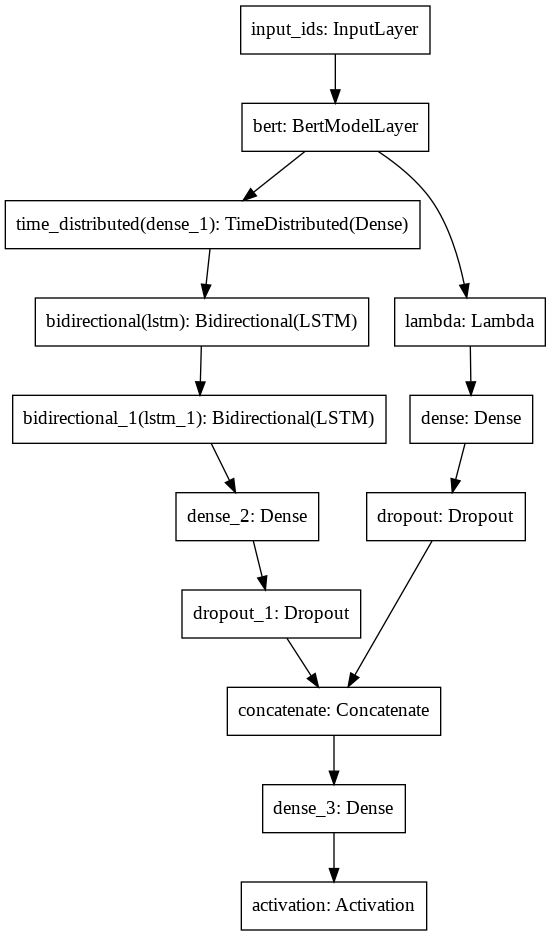

In [39]:
plot_model(model, to_file='model.png')

## Training

In [0]:
def train_test_input_fn(batch_size=256):
    # Convert the inputs to a Dataset.
    dataset_train = tf.data.Dataset.from_tensor_slices((data.train_x,data.train_y))
    dataset_test = tf.data.Dataset.from_tensor_slices((data.test_x,data.test_y))
    dataset_val = tf.data.Dataset.from_tensor_slices((data.val_x,data.val_y))
    # Shuffle, repeat, and batch the examples.
    dataset_train = dataset_train.cache()
    dataset_train = dataset_train.shuffle(1000, reshuffle_each_iteration=True)
    dataset_train = dataset_train.repeat()
    dataset_train = dataset_train.batch(batch_size, drop_remainder=True)
    dataset_test = dataset_test.cache()
    dataset_test = dataset_test.shuffle(1000, reshuffle_each_iteration=True)
    dataset_test = dataset_test.repeat()
    dataset_test = dataset_test.batch(batch_size, drop_remainder=True)
    dataset_val = dataset_val.cache()
    dataset_val = dataset_val.shuffle(1000, reshuffle_each_iteration=True)
    dataset_val = dataset_val.repeat()
    dataset_val = dataset_val.batch(batch_size, drop_remainder=True)
    # Return the dataset.
    return dataset_train,dataset_test,dataset_val


In [41]:
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
    print('TPU not found')

Found TPU at: grpc://10.97.103.2:8470


In [42]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)


INFO:tensorflow:Initializing the TPU system: 10.97.103.2:8470


INFO:tensorflow:Initializing the TPU system: 10.97.103.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [47]:
with strategy.scope():
  model = create_model(data.max_seq_len, bert_ckpt_file)
  model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'], )

train_dataset, test_dataset, val_dataset = train_test_input_fn()

model.fit(train_dataset,
          epochs=20,
          steps_per_epoch = 128,
          validation_data=val_dataset,
          validation_steps=3
          )


Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f69e300a518> (prefix:bert_4). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Train for 128 steps, validate for 3 steps
Epoch 1/20
128/128 [==============================] - 59s 460ms/step - loss: 2.5963 - accuracy: 0.2951 - val_loss: 2.0958 - val_accuracy: 0.3060
Epoch 2/20
128/128 [==============================] - 23s 182ms/step - loss: 1.9598 - accuracy: 0.5086 - val_loss: 1.5838 - val_accuracy: 0.5430
Epoch 3/20
128/128 [=======

In [136]:
score = model.evaluate(test_dataset,steps=3) 

3/3 [==============================] - 8s 3s/step - loss: 0.8044 - accuracy: 0.7500


In [137]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 75.0


Evaluation

The overall accuracy is 

### Minority Class

In [0]:
# Generate predictions for the test data
pred_test = model.predict(test_dataset,steps=218) # 55902/256

In [142]:
from collections import Counter
y_test = [np.asarray(row[1:],dtype=np.float32) for row in test.values]
pred_1d = np.argmax(pred_test, axis=1)
test_1d = np.argmax(y_test, axis=1)

print("Predicted Class: ", Counter(list(pred_1d)))
print("Test Class: ", Counter(list(test_1d)))
# print("One hot encoded dict class: ", one_hot_encoding_dict)

55808
Predicted Class:  Counter({38: 25370, 11: 11471, 1: 3933, 0: 3805, 39: 3341, 6: 2088, 36: 1415, 34: 880, 42: 874, 13: 733, 27: 623, 20: 356, 24: 279, 16: 219, 17: 167, 4: 55, 8: 55, 37: 52, 21: 32, 22: 27, 18: 24, 29: 6, 12: 2, 15: 1})
Test Class:  Counter({38: 18478, 11: 9287, 39: 6505, 1: 4592, 0: 4141, 6: 3057, 36: 1341, 13: 1264, 42: 823, 29: 792, 20: 656, 34: 530, 27: 432, 21: 408, 17: 333, 24: 313, 37: 254, 16: 251, 25: 235, 31: 213, 4: 186, 5: 185, 2: 177, 8: 177, 15: 176, 32: 170, 12: 165, 9: 99, 18: 86, 28: 83, 26: 75, 10: 60, 33: 47, 40: 41, 14: 41, 22: 41, 7: 37, 19: 33, 30: 33, 41: 31, 3: 29, 35: 18, 23: 7})


(55808, 55902)

In [0]:
# Build the confusion matrix off these predictions
# matrix = confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))

In [120]:
pred_1d

array([38, 36, 38, 38, 38,  6, 38, 38, 39, 11, 38, 38, 11, 38, 38, 11, 38,
       38, 38, 38, 38, 38, 38, 38, 36, 39, 11, 38,  0, 38, 38, 38, 39,  6,
       38, 11, 38, 38, 11, 39,  0,  1,  1, 27, 11, 17, 38, 11, 11, 38, 11,
       38, 38, 38, 11, 39, 38, 11, 39, 38, 38,  6, 13, 11, 38, 36, 39, 38,
        0, 39, 38, 17, 11, 11, 11, 11, 11, 38, 38, 11, 38, 38,  1, 39, 38,
       38, 38, 11, 11, 11, 38, 27, 38, 38, 11, 36, 38, 11, 17, 38,  6, 38,
        6, 38, 39, 38, 38, 11, 27,  0, 38, 11, 11,  0, 27, 11, 11, 38, 38,
       39,  1,  0, 39, 11, 38, 38, 38, 38, 38, 11, 13, 38,  1, 11, 38, 38,
       38,  1, 11, 38, 39, 38, 38, 38,  0, 11, 11,  0, 38, 38, 38, 38,  0,
        6, 38, 11, 38, 38, 38, 17, 38, 38, 11, 38, 38, 42, 38, 13,  1, 11,
       38, 38, 11, 38, 38, 13,  1, 38, 11, 27, 38, 38, 38, 38, 38, 38, 38,
       38,  0, 38, 38, 17, 11,  0,  0, 39, 38, 11, 13, 38, 38, 11, 38, 27,
       38, 38, 38, 38,  0, 38, 11, 38, 38, 38, 38, 36, 11, 11, 38,  0, 39,
       38, 38,  0, 38, 38

# References

- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines
- https://jalammar.github.io/illustrated-bert/
- https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
- https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/